# 07_compute_ILC

compute interlobe correlation

In [2]:
import numpy as np
from os.path import join as pjoin
from os.path import isdir
import os
import matplotlib.pyplot as plt
from matplotlib import cm, colors
import mne_bids
import mne
from mne_bids import write_raw_bids, BIDSPath
from scipy import stats
import re
from scipy import signal
import pandas as pd
from scipy import signal, fftpack
from scipy.spatial.distance import cdist

In [3]:
# define variables
sub_list = ['{0:0>2d}'.format(sub) for sub in np.arange(1,12)]
run_list = ['{0:0>2d}'.format(run) for run in np.arange(1,9)]

# set path
pre_root = '/nfs/e5/studyforrest/forrest_movie_meg/gump_meg_bids'
post_root = pjoin(pre_root, 'derivatives', 'preproc_meg-mne_mri-fmriprep')

results_pth = '/nfs/e5/studyforrest/forrest_movie_meg/tech_val_results'
if os.path.exists(results_pth) is False:
    os.mkdir(results_pth)

In [4]:
def extract_megdata(bids_root, sub, run):

    sub_path = BIDSPath(subject=sub, run=run, task='movie', session='movie', root=bids_root)
    raw = mne_bids.read_raw_bids(sub_path)
    
    return raw

In [5]:
def extract_events(bids_root, sub, run):
    
    raw = extract_megdata(bids_root, sub, run)
    events = mne.find_events(raw, stim_channel='UPPT001', min_duration=2/raw.info['sfreq'])
    
    return events

In [6]:
def get_picks(data):
    # get valid channels
    ch_name_picks = mne.pick_channels_regexp(data.ch_names, regexp='M[LRZ]...-4503')
    type_picks = mne.pick_types(data.info, meg=True)
    picks= np.intersect1d(ch_name_picks, type_picks)
    return picks

In [7]:
def compute_isfc(data1, data2=None):

    """calculate inter-subject correlation along the determined axis.

    Parameters
    ----------
        data1: used to calculate functional connectivity,
            shape = [n_samples1, n_features].
        data2: used to calculate functional connectivity,
            shape = [n_samples2, n_features].

    Returns
    -------
        isfc: functional connectivity map of data1 and data2,
            shape = [n_samples1, n_samples2].

    """
    if data2 is None:
        data2 = data1
        
    data1 = np.nan_to_num(data1)
    data2 = np.nan_to_num(data2)
    
    corr = np.nan_to_num(1 - cdist(data1, data2, metric='correlation'))
    return corr

In [11]:
def compute_ILC(data_sub, events_sub, picks_ref):
    """
    
    """  
    picks_sub = get_picks(data_sub)

    # match channels
    picks = np.intersect1d(picks_sub, picks_ref)
    
    # mark bad channels
    bad_idx = []
    if len(picks) != len(picks_ref):
        bad_picks = np.union1d(np.setdiff1d(picks_sub, picks_ref), np.setdiff1d(picks_ref, picks_sub))
        for chn in bad_picks:
            bad_idx.append(np.where(picks == chn)[0][0])
    
    meg_data = data_sub.get_data(picks=picks)  
    
    # hilbert xfm
    envlope = np.abs(signal.hilbert(meg_data))
    
    if len(bad_idx) != 0:
        for idx in bad_idx:
            envlope[idx,:] = 0
    
    # downsampling
    envlope_dsamp = envlope.take(events_sub[1:-1:25,0], axis=1)
    
    ilc = compute_isfc(envlope_dsamp)
    del data_sub
    
    return ilc

In [16]:
# compute ILC
# get ref picks
data_ref = extract_megdata(pre_root, '01', '01')
picks_ref = get_picks(data_ref)

ilc = {}
for sub in sub_list:
    ilc[sub] = []
    if sub == '01':
        run_ls = run_list + ['09']
    else:
        run_ls = run_list
    
    for run in run_ls:      
        megdata = extract_megdata(post_root, sub, run)
        events = extract_events(post_root, sub, run)
        ilc[sub].append(compute_ILC(megdata, events, picks_ref))


ds directory : /nfs/e5/studyforrest/forrest_movie_meg/gump_meg_bids/sub-01/ses-movie/meg/sub-01_ses-movie_task-movie_run-01_meg.ds
    res4 data read.
    hc data read.
    Separate EEG position data file read.
    Quaternion matching (desired vs. transformed):
       4.65   74.88    0.00 mm <->    4.65   74.88    0.00 mm (orig :  -65.68   46.24 -249.17 mm) diff =    0.000 mm
      -4.65  -74.88    0.00 mm <->   -4.65  -74.88    0.00 mm (orig :   42.00  -58.24 -250.44 mm) diff =    0.000 mm
      92.94    0.00    0.00 mm <->   92.94   -0.00    0.00 mm (orig :   46.46   62.07 -225.18 mm) diff =    0.000 mm
    Coordinate transformations established.
    Polhemus data for 3 HPI coils added
    Device coordinate locations for 3 HPI coils added
    Measurement info composed.
Finding samples for /nfs/e5/studyforrest/forrest_movie_meg/gump_meg_bids/sub-01/ses-movie/meg/sub-01_ses-movie_task-movie_run-01_meg.ds/sub-01_ses-movie_task-movie_run-01_meg.meg4: 
    System clock channel is availabl

KeyboardInterrupt: 

In [ ]:
# save ILC data
for sub in list(ilc.keys())[1:]:
    ilc[sub].append(np.nan)
df = pd.DataFrame(ilc, columns=sub_list, index=run_list+['09'])
df.to_pickle(pjoin(results_pth, 'ilc.pickle'))

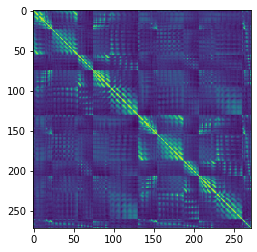

In [24]:
plt.imshow(ilc['01'][0])